In [1]:
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt

In [2]:
#testing Level's proposition on gershman 2009's model

In [13]:
#parallisation on Gershman 09's model
#p: no. simulations running in parallel
def likelihood_new(z,a,b,sigma_a,sigma_b,p):
    #bi-modal, mixture of Gaussian function
    #2 peaks at -1 and 1
    #return: a scalar, p(x|z) as a functino of z
    likelihood_ele = 1/sigma_a*np.exp(-0.5/sigma_a**2*(z.reshape((p,-1))-a)**2) + 1/sigma_b*np.exp(-0.5/sigma_b**2*(z.reshape((p,-1))-b)**2)
    return np.prod(likelihood_ele,axis=1)

def proposal_function_new(z, p, sigma1 = 1.5):
    #generate a new proposal from the current sample
    #change only one element at a time!
    dim = z.shape[1]
    z_star = z.copy()
    i = random.randint(0,dim)
    j = random.randint(0,dim)
    index = random.randint(0,dim,(p,2))
    for i in range(p):
        z_star[i,index[i,0],index[i,1]] = z_star[i,index[i,0],index[i,1]] + sigma1*np.random.normal()
    return z_star

def MRF_prior_new(z,lamda,p):
    #return the Gaussian MRF of the perception
    #'reflection on boundary first
    dim = z.shape[1]
    z_extended = np.concatenate((z[:,:,0].reshape(p,-1,1),z,z[:,:,-1].reshape(p,-1,1)),axis=2)
    z_extended = np.concatenate((z_extended[:,0,:].reshape(p,1,-1),z_extended,z_extended[:,-1,:].reshape(p,1,-1)),axis=1)
    sum_dis = np.sum(np.sum((z-z_extended[:,:dim,1:dim+1])**2,axis=1),axis=1)+np.sum(np.sum((z-z_extended[:,2:,1:dim+1])**2,axis=1),axis=1)
    sum_dis = sum_dis+np.sum(np.sum((z-z_extended[:,1:dim+1,:dim])**2,axis=1),axis=1)+np.sum(np.sum((z-z_extended[:,1:dim+1:,2:])**2,axis=1),axis=1)
    return np.exp(-lamda*sum_dis)

def sample_rejection_new(z,z_star,p,a, b, sigma_a, sigma_b, lamda):
    #input: z is the current sample
    #z_star is the proposed sample
    #if sample accepted: return True
    #if rejected: return False
    p_z = likelihood_new(z,a,b,sigma_a,sigma_b,p)*MRF_prior_new(z,lamda,p)
    p_z_star = likelihood_new(z_star,a,b,sigma_a,sigma_b,p)*MRF_prior_new(z_star,lamda,p)
    p_acc = p_z_star/p_z
    p_ran = random.random(p)
    acc = np.sign(p_acc-p_ran).astype('int')
    return acc

def simulation(p,no_samples,a = 1, b = -1, sigma_a = 0.3, sigma_b = 0.3, lamda = 0.05,dim = 4):
    state_list_par = []
    #define initial z
    z = (np.random.rand(p,dim,dim)-0.5)*2
    for i in range(int(no_samples)):
        z_star = proposal_function_new(z,p)
        acc = sample_rejection_new(z,z_star,p,a, b, sigma_a, sigma_b, lamda)
        for j in range(p):
            if acc[j] == 1:
                z[j,:,:] = z_star[j,:,:]
        z_a = z.copy()
        state_list_par.append(z_a)
    return state_list_par

In [34]:
#from node's state to the no. node > 0.5 in each step
def node_count(s,p,no_sample):
    state_no_array = []
    for i in range(p):
        state_no_array_i = []
        for j in range(no_sample):
            state_no_array_i.append(len(np.where(s[j,i,:,:]>0)[0]))
        state_no_array.append(state_no_array_i)
    state_no_array = np.array(state_no_array)
    return state_no_array

In [10]:
def domi_period_count(state_list_input,dim):
    cross_list = []
    #element in cross list: (index,cross_type)
    #cross type = 1: upper bound going up
    #cross type = 2: lower bound going down
    for i in range(1,len(state_list_input)):
        if state_list_input[i-1]>dim**2*1/3 and state_list_input[i]<dim**2*1/3:
            cross_list.append((i,2))
        elif state_list_input[i-1]<dim**2*2/3 and state_list_input[i]>dim**2*2/3:
            cross_list.append((i,1))
    switch_list = [cross_list[0]]
    cross = cross_list[0][1]
    for i in range(1,len(cross_list)):
        if cross_list[i][1] != cross:
            cross = cross_list[i][1]
            switch_list.append(cross_list[i])
    domi_list =[]
    for i in range(1,len(switch_list)):
        domi_list.append(switch_list[i][0]-switch_list[i-1][0])
    return domi_list

def hist_plot(x,n):
    plt.hist(x,n)
    return np.mean(x),np.std(x)

def generate_domi_list(state_count,dim):
    domi_list = []
    for state_list_i in state_count:
        domi_list_i = domi_period_count(state_list_i,dim)
        domi_list = domi_list + domi_list_i
    return domi_list

In [14]:
p,no_samples,a, b, sigma_a, sigma_b, lamda,dim = 100, 44000, 1, -1, 0.3, 0.3, 0.05, 4
s_03_03 = simulation(p,no_samples,a, b, sigma_a, sigma_b, lamda,dim)
print('done')

p,no_samples,a, b, sigma_a, sigma_b, lamda,dim = 100, 44000, 1, -1, 0.4, 0.3, 0.05, 4
s_04_03 = simulation(p,no_samples,a, b, sigma_a, sigma_b, lamda,dim)
print('done')

p,no_samples,a, b, sigma_a, sigma_b, lamda,dim = 100, 44000, 1, -1, 0.5, 0.3, 0.05, 4
s_05_03 = simulation(p,no_samples,a, b, sigma_a, sigma_b, lamda,dim)
print('done')

p,no_samples,a, b, sigma_a, sigma_b, lamda,dim = 100, 44000, 1, -1, 0.2, 0.3, 0.05, 4
s_02_03 = simulation(p,no_samples,a, b, sigma_a, sigma_b, lamda,dim)
print('done')

p,no_samples,a, b, sigma_a, sigma_b, lamda,dim = 100, 44000, 1, -1, 0.1, 0.3, 0.05, 4
s_01_03 = simulation(p,no_samples,a, b, sigma_a, sigma_b, lamda,dim)
print('done')

p,no_samples,a, b, sigma_a, sigma_b, lamda,dim = 100, 44000, 1, -1, 0.05, 0.3, 0.05, 4
s_005_03 = simulation(p,no_samples,a, b, sigma_a, sigma_b, lamda,dim)
print('done')

p,no_samples,a, b, sigma_a, sigma_b, lamda,dim = 100, 44000, 1, -1, 0.2, 0.2, 0.05, 4
s_02_02 = simulation(p,no_samples,a, b, sigma_a, sigma_b, lamda,dim)
print('done')

p,no_samples,a, b, sigma_a, sigma_b, lamda,dim = 100, 44000, 1, -1, 0.1, 0.1, 0.05, 4
s_01_01 = simulation(p,no_samples,a, b, sigma_a, sigma_b, lamda,dim)
print('done')

p,no_samples,a, b, sigma_a, sigma_b, lamda,dim = 100, 44000, 1, -1, 0.4, 0.4, 0.05, 4
s_04_04 = simulation(p,no_samples,a, b, sigma_a, sigma_b, lamda,dim)
print('done')

p,no_samples,a, b, sigma_a, sigma_b, lamda,dim = 100, 44000, 1, -1, 0.5, 0.5, 0.05, 4
s_05_05 = simulation(p,no_samples,a, b, sigma_a, sigma_b, lamda,dim)
print('done')

done
done
done
done
done
done
done
done
done
done


In [35]:
ave_03_03 = np.mean(np.array(generate_domi_list(node_count(np.array(s_03_03),p,no_samples),dim)))
print(ave_03_03)

ave_04_03 = np.mean(np.array(generate_domi_list(node_count(np.array(s_04_03),p,no_samples),dim)))
print(ave_04_03)

ave_05_03 = np.mean(np.array(generate_domi_list(node_count(np.array(s_05_03),p,no_samples),dim)))
print(ave_05_03)

ave_02_03 = np.mean(np.array(generate_domi_list(node_count(np.array(s_02_03),p,no_samples),dim)))
print(ave_02_03)

ave_01_03 = np.mean(np.array(generate_domi_list(node_count(np.array(s_01_03),p,no_samples),dim)))
print(ave_01_03)

ave_02_02 = np.mean(np.array(generate_domi_list(node_count(np.array(s_02_02),p,no_samples),dim)))
print(ave_02_02)

ave_01_01 = np.mean(np.array(generate_domi_list(node_count(np.array(s_01_01),p,no_samples),dim)))
print(ave_01_01)

ave_04_04 = np.mean(np.array(generate_domi_list(node_count(np.array(s_04_04),p,no_samples),dim)))
print(ave_04_04)

ave_05_05 = np.mean(np.array(generate_domi_list(node_count(np.array(s_05_05),p,no_samples),dim)))

534.7040187376725
468.0814655172414
438.5583720460513
697.2297776345472
1155.4167343623071
828.0418828049952
1636.8533384793516
396.6132350263972


In [16]:
print(ave_05_05)

421.2880434782609


Text(0, 0.5, 'mean dominance duration')

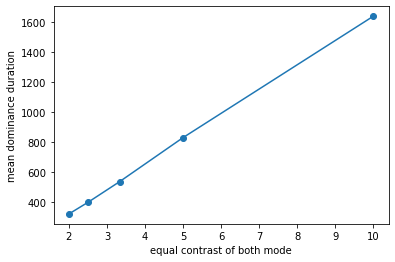

In [36]:
plt.plot(np.array([1/0.5,1/0.4,1/0.3,1/0.2,1/0.1]),np.array([ave_05_05,ave_04_04,ave_03_03,ave_02_02,ave_01_01]))
plt.scatter(np.array([1/0.5,1/0.4,1/0.3,1/0.2,1/0.1]),np.array([ave_05_05,ave_04_04,ave_03_03,ave_02_02,ave_01_01]))
plt.xlabel('equal contrast of both mode')
plt.ylabel('mean dominance duration')

Text(0, 0.5, 'average dominance duration')

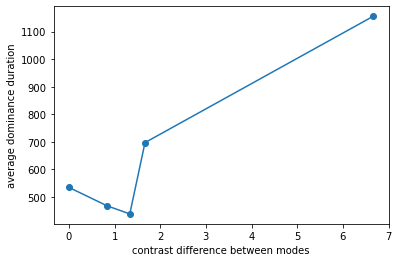

In [37]:
plt.plot(np.array([1/0.3-1/0.3,1/0.3-1/0.4,1/0.3-1/0.5,1/0.2-1/0.3,1/0.1-1/0.3]),np.array([ave_03_03,ave_04_03,ave_05_03,ave_02_03,ave_01_03]))
plt.scatter(np.array([1/0.3-1/0.3,1/0.3-1/0.4,1/0.3-1/0.5,1/0.2-1/0.3,1/0.1-1/0.3]),np.array([ave_03_03,ave_04_03,ave_05_03,ave_02_03,ave_01_03]))
plt.xlabel('contrast difference between modes')
plt.ylabel('average dominance duration')

In [38]:
def domi_period_count_new(state_list_input,dim):
    cross_list = []
    #element in cross list: (index,cross_type)
    #cross type = 1: upper bound going up
    #cross type = 2: lower bound going down
    for i in range(1,len(state_list_input)):
        if state_list_input[i-1]>dim**2*1/3 and state_list_input[i]<1/3*dim**2:
            cross_list.append((i,2))
        elif state_list_input[i-1]<2/3*dim**2 and state_list_input[i]>2/3*dim**2:
            cross_list.append((i,1))
    switch_list = [cross_list[0]]
    cross = cross_list[0][1]
    for i in range(1,len(cross_list)):
        if cross_list[i][1] != cross:
            cross = cross_list[i][1]
            switch_list.append(cross_list[i])
    domi_list =[]
    percept_list = []
    for i in range(1,len(switch_list)):
        domi_list.append(switch_list[i][0]-switch_list[i-1][0])
        percept_list.append(switch_list[i-1][1])
    return domi_list,percept_list

def generate_domi_percept_list(state_count,dim):
    domi_list = []
    percept_list = []
    for state_list_i in state_count:
        domi_list_i,percept_list_i = domi_period_count_new(state_list_i,dim)
        domi_list = domi_list + domi_list_i
        percept_list = percept_list+percept_list_i
    return domi_list,percept_list

In [39]:
domi_list_05_03,percept_list_05_03 = generate_domi_percept_list(node_count(np.array(s_05_03),p,no_samples),dim)
domi_list_04_03,percept_list_04_03 = generate_domi_percept_list(node_count(np.array(s_04_03),p,no_samples),dim)
domi_list_03_03,percept_list_03_03 = generate_domi_percept_list(node_count(np.array(s_03_03),p,no_samples),dim)
domi_list_02_03,percept_list_02_03 = generate_domi_percept_list(node_count(np.array(s_02_03),p,no_samples),dim)
domi_list_01_03,percept_list_01_03 = generate_domi_percept_list(node_count(np.array(s_01_03),p,no_samples),dim)

In [45]:
percept_list_05_03

[2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,


In [40]:
def predomi_count(domi_period,domi_percept):
    domi_1 = 0
    domi_2 = 0
    for i in range(len(domi_period)):
        if domi_percept[i] == 1:
            domi_1 = domi_1 + domi_period[i]
        else:
            domi_2 = domi_2 + domi_period[i]
    return domi_1/np.sum(domi_period),domi_2/np.sum(domi_period)

def ave_domi_count(domi_period,domi_percept):
    domi_1_t = 0
    domi_2_t = 0
    domi_1_count = 0
    domi_2_count = 0
    for i in range(len(domi_period)):
        if int(domi_percept[i]) == 1:
            domi_1_t = domi_1_t + domi_period[i]
            domi_1_count = domi_1_count +1
        else:
            domi_2_t = domi_2_t + domi_period[i]
            domi_2_count = domi_2_count +1
    return domi_1_t/domi_1_count, domi_2_t/domi_2_count

In [49]:
predomi_list = [predomi_count(domi_list_05_03,percept_list_05_03)[0]]
predomi_list.append(predomi_count(domi_list_04_03,percept_list_04_03)[0])
predomi_list.append(predomi_count(domi_list_03_03,percept_list_03_03)[0])
predomi_list.append(predomi_count(domi_list_02_03,percept_list_02_03)[0])
predomi_list.append(predomi_count(domi_list_01_03,percept_list_01_03)[0])

In [52]:
contrast_array = np.array(10/np.arange(1,6,1))

Text(0, 0.5, 'predominance of mode 1')

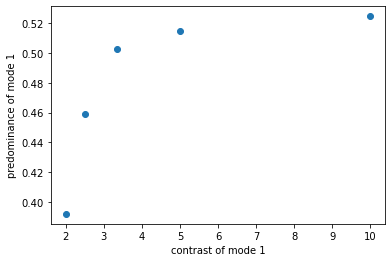

In [54]:
plt.scatter(contrast_array,np.flip(np.array(predomi_list)))
plt.xlabel('contrast of mode 1')
plt.ylabel('predominance of mode 1')

In [55]:
ave_domi_1 = []
ave_domi_2 = []
ave_01_03 = ave_domi_count(domi_list_01_03,percept_list_01_03)
ave_domi_1.append(ave_01_03[0])
ave_domi_2.append(ave_01_03[1])

ave_02_03 = ave_domi_count(domi_list_02_03,percept_list_02_03)
ave_domi_1.append(ave_02_03[0])
ave_domi_2.append(ave_02_03[1])

ave_03_03 = ave_domi_count(domi_list_03_03,percept_list_03_03)
ave_domi_1.append(ave_03_03[0])
ave_domi_2.append(ave_03_03[1])

ave_04_03 = ave_domi_count(domi_list_04_03,percept_list_04_03)
ave_domi_1.append(ave_04_03[0])
ave_domi_2.append(ave_04_03[1])

ave_05_03 = ave_domi_count(domi_list_05_03,percept_list_05_03)
ave_domi_1.append(ave_05_03[0])
ave_domi_2.append(ave_05_03[1])

Text(0, 0.5, 'mean dominance duration')

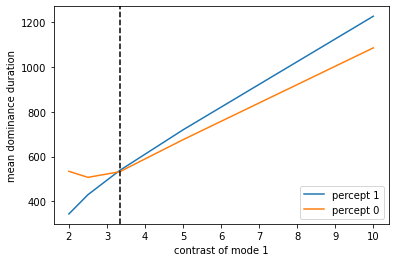

In [61]:
plt.plot(contrast_array,np.array(ave_domi_1))
plt.plot(contrast_array,np.array(ave_domi_2))
plt.axvline(x=1/0.3,color = 'k', linestyle= '--')
plt.legend(['percept 1', 'percept 0'])
plt.xlabel('contrast of mode 1')
plt.ylabel('mean dominance duration')

In [28]:
print(ave_domi_1)
print(ave_domi_2)
print(326.3339540657976-116.93103448275862)
print(327.86583850931675-481.16259931895576)

[713.6341189674523, 746.6793849658314, 640.4913920314806, 516.1242287124641, 326.583644278607, 273.45873715124816, 207.53177441540578, 154.81637107776262, 127.884561891516, 114.64546460176992]
[427.5142537730576, 404.98530243075186, 364.0059113300493, 331.04415372035976, 330.3219071361795, 345.6813768755516, 372.81633771929825, 421.89377389404694, 458.1694868238558, 467.4033149171271]
209.40291958303902
-153.296760809639


Text(0.5, 0, 'state of single node')

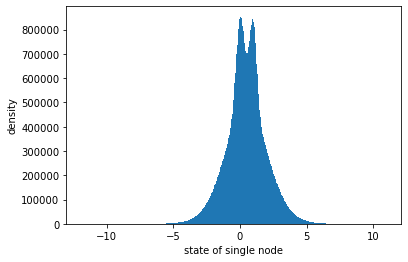

In [29]:
plt.hist(s_000075_0001.reshape(-1),500)
plt.ylabel('density')
plt.xlabel('state of single node')

In [98]:
var_0,var_1,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.005,0.005,10,10,0,1/100,0.5*np.ones((200,5,5)),5,200,11000
s_0005_0005 = simulation_new(var_0,var_1,beta,gamma,alpha,tau,b,dim,p,no_sample)
print('done')

var_0,var_1,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.0025,0.0025,10,10,0,1/100,0.5*np.ones((200,5,5)),5,200,11000
s_00025_00025 = simulation_new(var_0,var_1,beta,gamma,alpha,tau,b,dim,p,no_sample)
print('done')


var_0,var_1,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.00075,0.00075,10,10,0,1/100,0.5*np.ones((200,5,5)),5,200,11000
s_000075_000075 = simulation_new(var_0,var_1,beta,gamma,alpha,tau,b,dim,p,no_sample)
print('done')

var_0,var_1,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.0005,0.0005,10,10,0,1/100,0.5*np.ones((200,5,5)),5,200,11000
s_00005_00005 = simulation_new(var_0,var_1,beta,gamma,alpha,tau,b,dim,p,no_sample)
print('done')

var_0,var_1,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.00025,0.00025,10,10,0,1/100,0.5*np.ones((200,5,5)),5,200,11000
s_000025_000025 = simulation_new(var_0,var_1,beta,gamma,alpha,tau,b,dim,p,no_sample)
print('done')

var_0,var_1,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.0001,0.0001,10,10,0,1/100,0.5*np.ones((200,5,5)),5,200,11000
s_00001_00001 = simulation_new(var_0,var_1,beta,gamma,alpha,tau,b,dim,p,no_sample)

done
done
done
done
done


In [99]:
domi_list_0005_0005 = np.array(generate_domi_list(node_count(s_0005_0005,p,no_sample),dim))
ave_0005_0005 = np.mean(domi_list_0005_0005)

domi_list_00025_00025 = np.array(generate_domi_list(node_count(s_00025_00025,p,no_sample),dim))
ave_00025_00025 = np.mean(domi_list_00025_00025)

domi_list_000075_000075 = np.array(generate_domi_list(node_count(s_000075_000075,p,no_sample),dim))
ave_000075_000075 = np.mean(domi_list_000075_000075)

domi_list_00005_00005 = np.array(generate_domi_list(node_count(s_00005_00005,p,no_sample),dim))
ave_00005_00005 = np.mean(domi_list_00005_00005)

domi_list_000025_000025 = np.array(generate_domi_list(node_count(s_000025_000025,p,no_sample),dim))
ave_000025_000025 = np.mean(domi_list_000025_000025)

domi_list_00001_00001 = np.array(generate_domi_list(node_count(s_00001_00001,p,no_sample),dim))
ave_00001_00001 = np.mean(domi_list_00001_00001)

Text(0, 0.5, 'mean dominance duration')

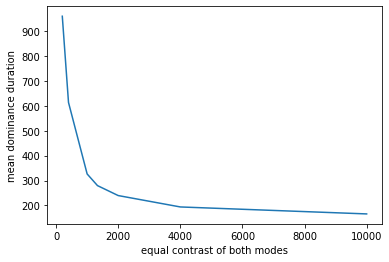

In [104]:
arr_x = np.array([1/0.005,1/0.0025,1/0.001,1/0.00075,1/0.0005,1/0.00025,1/0.0001])
arr_y = np.array([ave_0005_0005,ave_00025_00025,ave_0001_0001[0],ave_000075_000075,ave_00005_00005,ave_000025_000025,ave_00001_00001])
plt.plot(arr_x,arr_y)
plt.xlabel('equal contrast of both modes')
plt.ylabel('mean dominance duration')